# Introduction
L1 instruction cache: 192KB (hw.perflevel0.l1icachesize: 196608)
L1 data cache: 128KB (hw.perflevel0.l1dcachesize: 131072)
L2 cache: 16MB (hw.perflevel0.l2cachesize: 16777216)

### how we validate
By using numpyt to write the output of A @ B to tmp/matmul we can read the and compare the output of our GEMM

### how we measure improvements
Gflops

### run commands and flags?
`-std=c++17 -Xpreprocessor -fopenmp -O3 -march=native -mcpu=native -ffast-math -I/opt/homebrew/include -L/opt/homebrew/lib -lomp -o`




# Stupid implementation


### python

```python
for i in range(N):
    for j in range(N):
        for k in range(N):
            C[i][j] += A[i][k] * B[k][j]
```

average gflops: 0.015153

N: 256


### cpp

```cpp
void gemm_stupid(){
    for (int i = 0; i < N; i++)
        for (int j = 0; j < N; j++) {
            for (int k = 0; k < N; k++)
                C[i][j] += A[i][k] * B[k][j];
        }
}
```

average gflops: 3.738789

N: 256




# numpy (single threaded)

We use the library threadpoolctl to force numpy into only using a single thread as shown below.

```python
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1):
    pass
```

We use numpys `@`operator to do the matrix multiplication

```python
def gemm():
    return A @ B
```

average gflops: 43.073460

N: 2048

# numpy (multi threaded)

numpy by default is multithreaded so we will be testing out how good default numpy is.

We get an average gflops of 138, which is impressive but numpy can do much better.\
Something very important to note is the way we generate the initial matrcies,\
more importantly their byte sizes.




In [ ]:
import numpy as np

A = np.random.random((N, N))
B = np.random.random((N, N))

print(A.dtype)

: 

From this we can observe that numpys default array type is float64,\
wich means that we can save up on alot of memory by converging these to float32,\
squizzing numpy to its best performence.

We do the same test as above but with

```python
A = np.random.random((N, N)).astype(np.float32)
B = np.random.random((N, N)).astype(np.float32)
```

This gives us an impressive average of *390.94* - impressive!

We will be using this number as reference since c++ float is float32 by default (other wise double)

Here is the current table

| Descritiopn   | Gflops | N    |
|---------------|--------|------|
| Python Stupid | 0.015  | 256  |
| C++ Stupid    | 3.738  | 256  |
| ST_Numpy      | 43.073 | 2048 |
| Numpy         | 390.94 | 2048 |


We will circle back to the cpp stupid implemetation and try to achieve the high preformace of numpy,
and even beat it.

# Transposing 



By transposing **B**, the entreis we fetch should be more continougs,\
thus reducing our cache misses.

Having the matricies 1D should also help with cache misses, but with our testing it does not give us any\
perfmorece edge, rather it makes it a bit slower. So we will stick with 2D arrays.\

We think that the -O2 / -O3 might be optimizing the 2D arrays better.

We get an average of 35.651 Gflops for the transposed version, which is a huge imporvement over the non transpose.



| Descritiopn   | Gflops | N    |
|---------------|--------|------|
| Python Stupid | 0.015  | 256  |
| C++ Stupid    | 3.738  | 256  |
| Numpy ST     | 43.073 | 2048 |
| Numpy MT        | 390.94 | 2048 |
| C++ Transposed      | 35.651 | 2048 |



# Threading with OMP

Before going over to doing Blocking and Unrolling, we will test out the transpose version with OMP threading.\
We are doing this because we think that Blocking and Unrolling will have a much bigger affect once we do gemm with threading.

we will use

`#pragma omp parallel for cllapse(2) private(bj, bk, i, j) shared(A, BT, C)`

# EXPLAIN WHY (page 96)

Average flops: 180.751


# Blocking

Next we are trying blocking, we will add three outer loops to create a smaller matrix\¨
that we focus on, then tiling up as we finish the matrix.



### why does blocking even help? (images and memory)

### theoretical best based on cache size

## testing best 

We tested the variante that has **threading** and **transposing**
- Threading
- Transposed

| blockSize                              | Matrix Size | FLOP/s
|------------------------------------------|-------------|----------------
| 4                                 | 2048        | 198.258 GFLOPS
| 8                                 | 2048        | 132.660 GFLOPS
| 16                                | 2048        | 60.810 GFLOPS
| 32                                | 2048        | 62.349 GFLOPS
| 64                                | 2048        | 169.871 GFLOPS
| 128                                | 2048        | 224.167 GFLOPS
| 256                                | 2048        | 121.976 GFLOPS

(worse over)

# GRAPH THE ABOVE

# Unrolling

Unrolling is very nice idea that will help us remove the inner most loop by unrolling it.

- doing the if statement logic (compiler wise) is expensive


our currentl inner loop looks like this
```cpp
..
for (j = 0; j < blockSize; j++) 
    for (k = 0; k < blockSize; k++){
        C[bi + i][bj + j] += A[bi + i][bk + k] * B_trans[bj + j][bk + k];
    }
..

```

We have an issue where the inner most if loop is being updated for each entry of `k`
and this is expensive since the compiler needs to do extra work, and extra memory usage is done here to fetch and upate `k`

we can reduce this workload by unrolling `x` amount of instruciont and writing them down manually.

for example unrolling by 4 instrucionts would look like this

```cpp
..
for (j = 0; j < blockSize; j++) 
    for (k = 0; k < blockSize; k+4){
        C[bi + i][bj + j] += A[bi + i][bk + 0] * B_trans[bj + j][bk + 0];
        C[bi + i][bj + j] += A[bi + i][bk + 1] * B_trans[bj + j][bk + 1];
        C[bi + i][bj + j] += A[bi + i][bk + 2] * B_trans[bj + j][bk + 2];
        C[bi + i][bj + j] += A[bi + i][bk + 3] * B_trans[bj + j][bk + 3];
    }
..

```

However, our testing shows that this barely gives any performace advantage. Neither did unrolling 8 instrctions.

The problem is that we are still using the if statement, so the best scenario would be to unroll all the instrucions and remove the if statement.

the innest most loop runs up to blocksize, meaning there would be the same amount of instrcionts as the block size, so we need to unroll 16 instrucions
to be able to remove the if statement

```cpp
..
for (j = 0; j < blockSize; j++) {
        C[bi + i][bj + j] += A[bi + i][bk + k] * B_trans[bj + j][bk + k];
        C[bi + i][bj + j] += A[bi + i][bk + k + 1] * B_trans[bj + j][bk + k + 1];
        C[bi + i][bj + j] += A[bi + i][bk + k + 2] * B_trans[bj + j][bk + k + 2];
        C[bi + i][bj + j] += A[bi + i][bk + k + 3] * B_trans[bj + j][bk + k + 3];

        C[bi + i][bj + j] += A[bi + i][bk + k + 4] * B_trans[bj + j][bk + k + 4];
        C[bi + i][bj + j] += A[bi + i][bk + k + 5] * B_trans[bj + j][bk + k + 5];
        C[bi + i][bj + j] += A[bi + i][bk + k + 6] * B_trans[bj + j][bk + k + 6];
        C[bi + i][bj + j] += A[bi + i][bk + k + 7] * B_trans[bj + j][bk + k + 7];

        C[bi + i][bj + j] += A[bi + i][bk + k + 8] * B_trans[bj + j][bk + k + 8];
        C[bi + i][bj + j] += A[bi + i][bk + k + 9] * B_trans[bj + j][bk + k + 9];
        C[bi + i][bj + j] += A[bi + i][bk + k + 10] * B_trans[bj + j][bk + k + 10];
        C[bi + i][bj + j] += A[bi + i][bk + k + 11] * B_trans[bj + j][bk + k + 11];

        C[bi + i][bj + j] += A[bi + i][bk + k + 12] * B_trans[bj + j][bk + k + 12];
        C[bi + i][bj + j] += A[bi + i][bk + k + 13] * B_trans[bj + j][bk + k + 13];
        C[bi + i][bj + j] += A[bi + i][bk + k + 14] * B_trans[bj + j][bk + k + 14];
        C[bi + i][bj + j] += A[bi + i][bk + k + 15] * B_trans[bj + j][bk + k + 15];
    }
..

```
Suprising, this also gave us very little performace advantage, so we played aroudn with the block size and found that a blocksize of 4 (corresponding to 4 unrooled instrctions) gives the best performace

Final loop:

```cpp
..
for (j = 0; j < blockSize; j++) {
    // Fully unrolled for blockSize = 4
    C[bi + i][bj + j] += A[bi + i][bk + 0] * B_trans[bj + j][bk + 0];
    C[bi + i][bj + j] += A[bi + i][bk + 1] * B_trans[bj + j][bk + 1];
    C[bi + i][bj + j] += A[bi + i][bk + 2] * B_trans[bj + j][bk + 2];
    C[bi + i][bj + j] += A[bi + i][bk + 3] * B_trans[bj + j][bk + 3];
}
..

```

average gflops: 299.380005
N = 2048

Very good but not as good as numpty 32byte arrays.


Table update:

| Descritiopn   | Gflops | N    |
|---------------|--------|------|
| Python Stupid | 0.015  | 256  |
| C++ Stupid    | 3.738  | 256  |
| Numpy ST     | 43.073 | 2048 |
| Numpy MT        | 390.94 | 2048 |
| C++ Transposed      | 35.651 | 2048 |
| C++ Transposed, OMP, Blocking=128      | 224.167 | 2048 |
| C++ Transposed, OMP, Unrolled  (blocking 4)     | 290.167 | 2048 |

# FMA

Fused Multiply-add is is an instruction that can execute X <- ax + b in the same amount as doing addtion and the multipcation, this is could potentioally help the processor with asymptotic speed per clock cycle[1]

At first we were not sure if -O3 was enabling FMA operations by default, so we tried the C++ Transposed and unroleld version with the `-mno-fma` and got 291.007 Glops, and with the `mfma` we got the same amount.

So the compiler might not be doing this by default.

we added `#pragma omp simd`to help the comlier and got a concistent 5-6 Gflop increase, 

```cpp
#pragma omp simd
for (j = 0; j < blockSize; j++) {
    C[bi + i][bj + j] += A[bi + i][bk + 0] * BT[bj + j][bk + 0];
    C[bi + i][bj + j] += A[bi + i][bk + 1] * BT[bj + j][bk + 1];
    C[bi + i][bj + j] += A[bi + i][bk + 2] * BT[bj + j][bk + 2];
    C[bi + i][bj + j] += A[bi + i][bk + 3] * BT[bj + j][bk + 3];
}
```

# talk about below (page 78)
`#pragma omp simd` vs `#pragma vector always`


Looking at the assebly code on a cpp explorer (https://godbolt.org/noscript) we can find a single mention of fmadd, suggesting that the compiler is using fma, even thoug hthe speed up of 5-8 Gflops is underwhelming - maybe we are not using its full potential?





### Cache locality

After further invastigation we relised that we are calculating the matrix in the wrong way,\
initially we were using the ijk approach, but the ikj approach should have a much better cache locallity

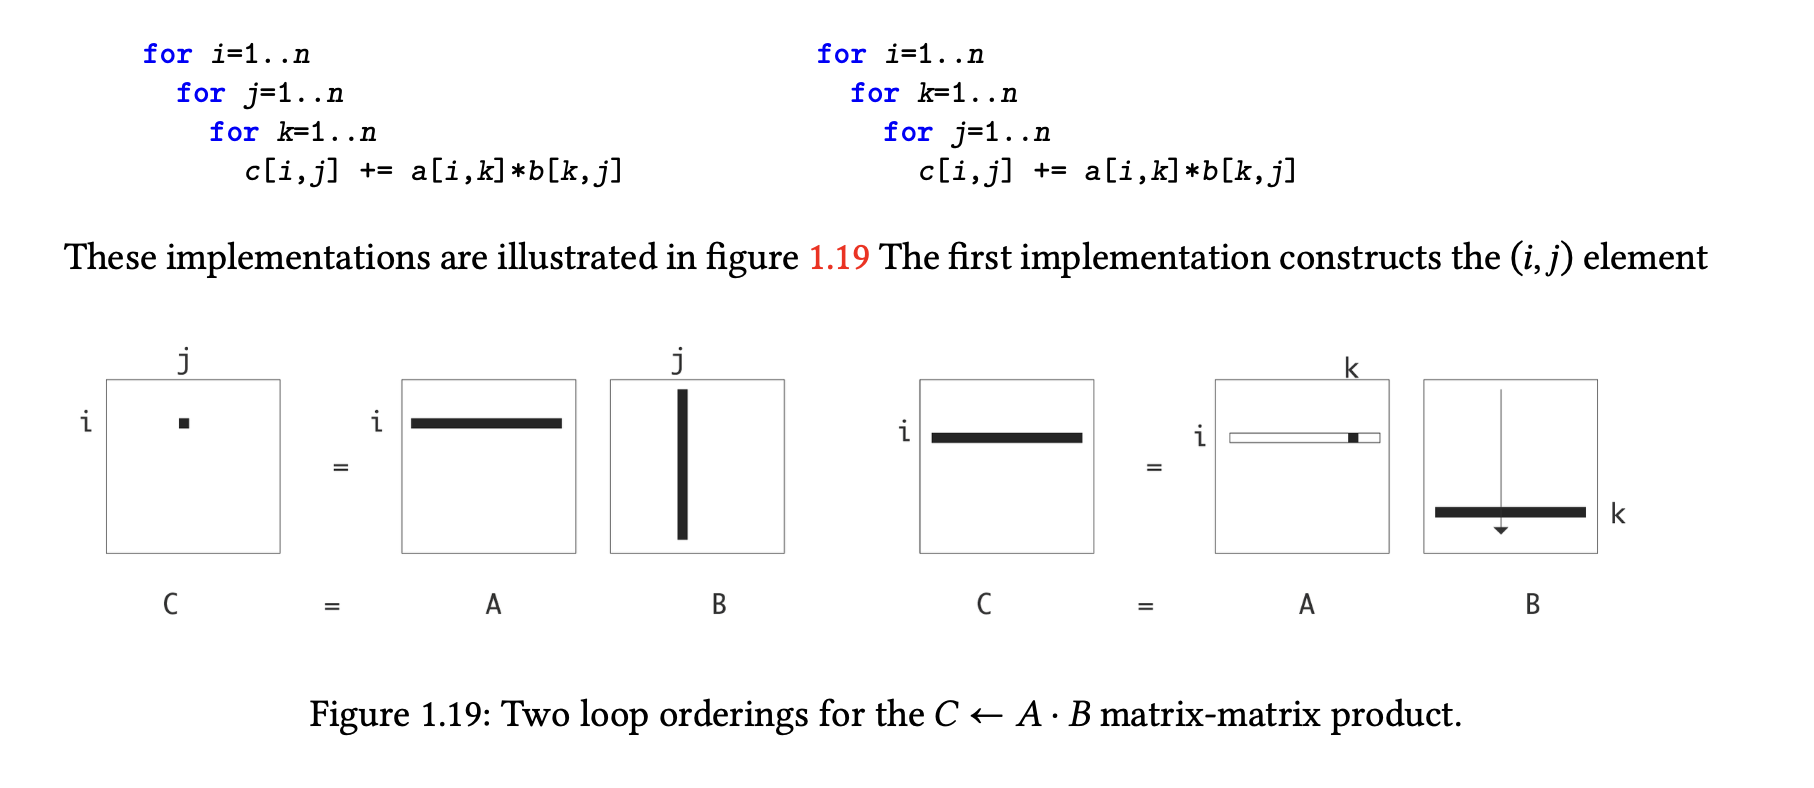


# EXPLAIN MORE WHy ITS GIOOD'
# ALSO UN-UNROLLOED; PRAGMA SMD FIXES ALREADy??

doing this gives an an impressive boost up to 410.236 Gflop! beating numpy!

| Descritiopn   | Gflops | N    |
|---------------|--------|------|
| Python Stupid | 0.015  | 256  |
| C++ Stupid    | 3.738  | 256  |
| Numpy ST     | 43.073 | 2048 |
| Numpy MT        | 390.94 | 2048 |
| C++ Transposed      | 35.651 | 2048 |
| C++ Transposed, OMP, Blocking=128      | 224.167 | 2048 |
| C++ Transposed, OMP, Unrolled  | 290.167 | 2048 |
| C++ Transposed, OMP, cache locallity       | 410.236 | 2048 |




### Larger N and memory bound

While we are very close to numpy with what we have, once we scale up N to 4096 and rarger, we can see a quite large decrese in Flops.

![](images/Figure_1.png)


We think that this is due to being memory bound, or the block size = 4 being limiting. so lets try to use larger block size





# Apple accelerate

# Assembly level instructions (AMX, NEON, gcc)




| Description                              | Matrix Size | FLOP/s
|------------------------------------------|-------------|----------------
| Python without numpy                     | 256         | 0.0092 GFLOPS 
| st_np_matmul.py                          | 512         | 15.374713 GFLOPS
| st_PTB64.cpp                             | 1024        | 17.178770 GFLOPS
| np_matmul.py                             | 1024         | 52.210830 GFLOPS
| matrix_mult.cpp                          | 1024        | 34.398815 GFLOPS
| st_PTB1D.cpp                             | 1024        | 31.425362 GFLOPS
| st_PTB16.cpp                               | 1024        | 40.412571 GFLOPS
| PTB1D.cpp                                | 1024        | 127.062523 GFLOPS
| PTB4.cpp                                 | 1024        | 101.024773 GFLOPS
| PTB8.cpp                                 | 1024        | 63.231953 GFLOPS
| PTB16.cpp                                | 2048        | 194.324829 GFLOPS
| PTB32.cpp                                | 1024        | 94.407333 GFLOPS
| PTBunroll.cpp                                | 2048        | GFLOPS: 296.469116
 

| accelerate.cpp                           | 8192        | 1326.189209 GFLOPS


(blocksize over 16 make yields less FLOPs)
(-O3 is faster than -O2 for me)


Run the best code
`clang++ PTB.cpp -O3 -march=native -ffast-math -Xpreprocessor -fopenmp -I/opt/homebrew/include -L/opt/homebrew/lib -lomp -o compiled/PTB && ./compiled/PTB`


Accelerate

`clang++ -O3 -DACCELRATE_NEW_LAPACK -DACCELERATE_LAPACK_ILP64 accelerate.cpp -framework Accelerate -o ./compiled/accelerate && ./compiled/accelerate`


### Questions

Blocking helps with cache, but why? same with unrolling 

#pragma omp parallel for private(bj, bk, i, j, k) shared(A, B_trans, C) - what does this do *exacly*? why is bi not included?

In [ ]:
### Sources

[1] The Art of HPC page 15/16

Blocking
- https://gist.github.com/metallurgix/8ee5262ed818730b5cc0



George Hotz
- (add yt video link)


Miduem Article
- https://vaibhaw-vipul.medium.com/matrix-multiplication-optimizing-the-code-from-6-hours-to-1-sec-70889d33dcfa


Neon Arm Instructions
- https://developer.arm.com/architectures/instruction-sets/intrinsics/#f:@navigationhierarchiessimdisa=[Neon]&f:@navigationhierarchiesreturnbasetype=[float]&f:@navigationhierarchieselementbitsize=[32]&q=vld1


Apple Accelerate
- https://developer.apple.com/documentation/accelerate/vdsp-library


- AMX
- https://zhen8838.github.io/2024/04/23/mac-amx_en/


Loop unrolling
- https://en.wikipedia.org/wiki/Loop_unrolling#:~:text=Loop%20unrolling%2C%20also%20known%20as,or%20by%20an%20optimizing%20compiler.

